<a href="https://colab.research.google.com/github/ihyaulumuddin044/ML_Portofolio/blob/main/Financial_Sentiment/Financial_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pendahuluan
## versi Indonesia:

Dalam dunia keuangan, analisis sentimen memiliki peran penting dalam memahami pandangan pasar terhadap berbagai aset dan peristiwa ekonomi. Untuk mendukung pengembangan penelitian di bidang ini, beberapa dataset seperti FiQA dan Financial PhraseBank telah dikombinasikan untuk menghasilkan sumber data yang kaya dan komprehensif. Dataset ini berisi kalimat keuangan yang telah diberi label sentimen, memungkinkan analisis yang lebih akurat terhadap opini pasar dan tren ekonomi. Salah satu referensi penting dalam konteks ini adalah karya Pekka Malo dkk. dalam penelitian mereka, "Good debt or bad debt: Detecting semantic orientations in economic texts" (Journal of the Association for Information Science and Technology, 2014), yang menjelaskan pentingnya deteksi orientasi semantik dalam teks ekonomi untuk memahami persepsi pasar secara lebih mendalam.


# 1. Import library yang di perlukan

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [98]:
df = pd.read_csv('financial_analisis.csv')
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


# 2. Exploratory Data Analysis (EDA)

pada tahap ini kita akan mengekplorasi data.

## 📊 Exploratory Data Analysis (EDA)

> **Memuat dan melihat sekilas data**  
> - Gunakan `pd.read_csv()` untuk memuat dataset.  
> - Gunakan `head()` untuk melihat beberapa baris pertama.  
> - Gunakan `info()` untuk melihat informasi dasar.  

> **Memeriksa nilai kosong dan duplikat**  
> - Gunakan `isnull().sum()` untuk melihat nilai yang hilang.  
> - Gunakan `duplicated().sum()` untuk melihat data duplikat.  

> **Distribusi label sentimen**  
> - Gunakan `value_counts()` untuk melihat distribusi kelas sentimen.  

> **Analisis panjang teks**  
> - Menghitung jumlah kata dan karakter untuk melihat distribusi panjang teks.  

> **Visualisasi distribusi sentimen**  
> - Menggunakan `matplotlib` atau `seaborn` untuk membuat grafik batang distribusi kelas.  

> **Preprocessing dasar teks**  
> - Menghapus tanda baca, angka, dan stopwords untuk membersihkan teks.  


In [99]:
df.shape

(5842, 2)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


* data terdiri dari 5842 baris dan 2 kolom dengan rincian satu kolom Sentence(Kalimat) dan kolom Sentiment(sentimen)
* kedua data bertipe objek yang berupa stirng

In [101]:
df.isna().sum()

,0
Sentence,0
Sentiment,0


In [102]:
print(df.duplicated().sum())

6


tidak ada data kosong dalam dataset tersebut tetapi ada 6 data duplikat. kita bisa menaganginya nanti.

Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64


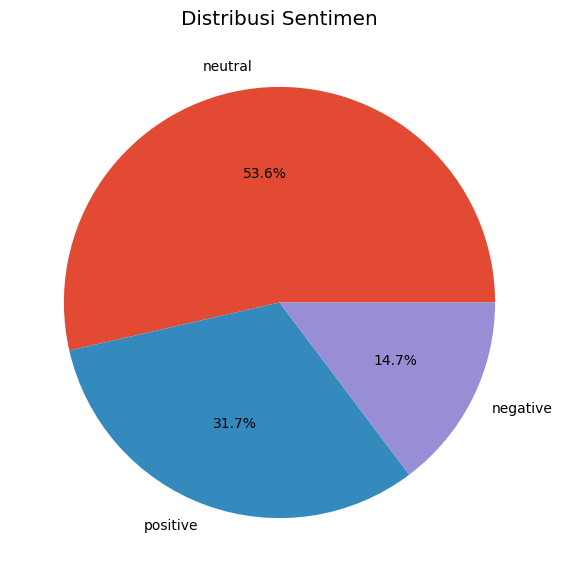

In [103]:
data = df.copy()

sentiment_counts = data['Sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(10, 7))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Distribusi Sentimen')
plt.show()

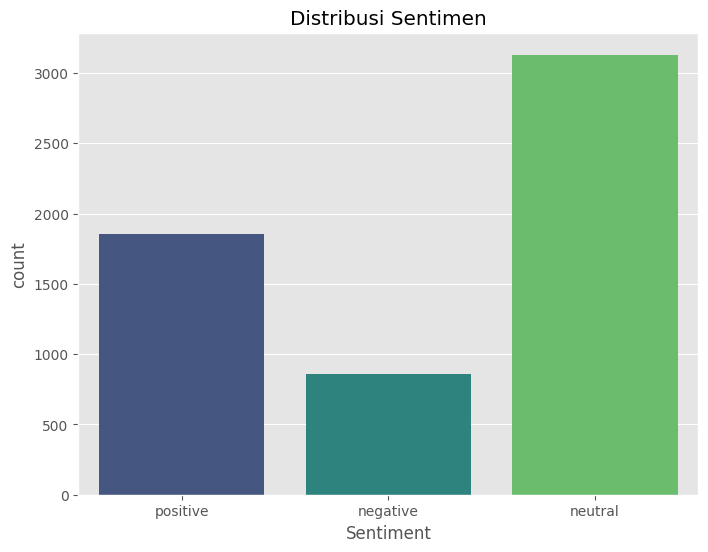

In [104]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Sentiment', palette='viridis')
plt.title("Distribusi Sentimen")
plt.show()

kita bisa melihat proporsi/distribusi data dari visualisasi pie chart dan diagram batang tersebut. dominasi data dalam dataset ini sebagina besar netral dan di ikuti sentimen postif lalu negatif yang paling akhir

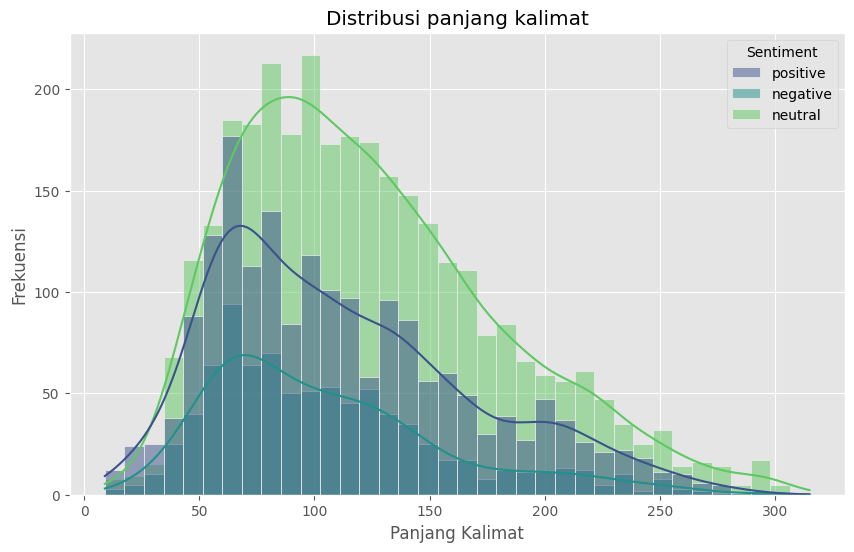

In [105]:
data['text_length'] = data['Sentence'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='text_length', hue='Sentiment', kde=True, palette='viridis')
plt.title('Distribusi panjang kalimat')
plt.xlabel('Panjang Kalimat')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

In [106]:
# Statistik panjang teks
print("\nStatistik Panjang Kalimat per Sentimen:")
print(data.groupby('Sentiment')['text_length'].describe())


Statistik Panjang Kalimat per Sentimen:
            count        mean        std   min   25%    50%     75%    max
Sentiment                                                                 
negative    860.0  105.330233  51.798956  12.0  66.0   94.0  132.25  296.0
neutral    3130.0  123.113419  56.872104   9.0  79.0  114.0  158.00  315.0
positive   1852.0  112.157127  56.412443  10.0  67.0  100.0  145.25  298.0


visualisi tersebut bisa menunjukkan ditibusi panjang kalimat dan bisa kita lihat juga bisa melihat data statistik

In [107]:
data.head()

,Sentence,Sentiment,text_length
0,The GeoSolutions technology will leverage Bene...,positive,218
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,55
2,"For the last quarter of 2010 , Componenta 's n...",positive,193
3,According to the Finnish-Russian Chamber of Co...,neutral,128
4,The Swedish buyout firm has sold its remaining...,neutral,135


# 3. Data Prepocessing

## 🛠️ Text Preprocessing

Untuk memastikan data teks siap digunakan dalam model machine learning, kita perlu melakukan beberapa langkah preprocessing, seperti menghapus karakter yang tidak perlu, mengonversi teks ke huruf kecil, dan menghapus kata-kata umum yang tidak memiliki makna penting (stopwords). Berikut langkah-langkah preprocessing yang digunakan:  

### **1. Mengunduh Resource NLTK**  
Pastikan resource NLTK yang diperlukan telah diunduh:  

```python
import nltk

# Pastikan NLTK resource sudah terunduh
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt")


In [108]:
# Pastikan NLTK resource sudah terunduh
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt_tab")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Menghapus karakter non-alfabet
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # Mengonversi ke huruf kecil
    text = text.lower()

    # Tokenisasi
    tokens = nltk.word_tokenize(text)

    # Menghapus stopwords dan melakukan lemmatization
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Gabungkan kembali menjadi satu teks
    return " ".join(cleaned_tokens)

# Menerapkan preprocessing ke setiap teks
data["cleaned_sentence"] = data["Sentence"].apply(preprocess_text)

# Contoh hasil
print(data[["Sentence", "cleaned_sentence"]].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                            Sentence  \
0  The GeoSolutions technology will leverage Bene...   
1  $ESI on lows, down $1.50 to $2.50 BK a real po...   
2  For the last quarter of 2010 , Componenta 's n...   
3  According to the Finnish-Russian Chamber of Co...   
4  The Swedish buyout firm has sold its remaining...   

                                    cleaned_sentence  
0  geosolutions technology leverage benefon gps s...  
1                        esi low bk real possibility  
2  last quarter componenta net sale doubled eur e...  
3  according finnish russian chamber commerce maj...  
4  swedish buyout firm sold remaining percent sta...  


bisa kita lihat, setelah melakukan Text Preprocessing kita berhasil:


* Menghapus karakter non-alfabet.

* Mengonversi ke huruf kecil.

* Melakukan tokenisasi untuk memisahkan kata-kata.

* Menghapus stopwords dan melakukan lemmatization.

* Menggabungkan kembali kata-kata yang sudah dibersihkan.

In [109]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # Bisa coba unigram + bigram
X = tfidf.fit_transform(data["cleaned_sentence"])
y = data["Sentiment"]
print(data.head())
print(data.shape)
print(X.shape)
print(y.shape)

                                            Sentence Sentiment  text_length  \
0  The GeoSolutions technology will leverage Bene...  positive          218   
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative           55   
2  For the last quarter of 2010 , Componenta 's n...  positive          193   
3  According to the Finnish-Russian Chamber of Co...   neutral          128   
4  The Swedish buyout firm has sold its remaining...   neutral          135   

                                    cleaned_sentence  
0  geosolutions technology leverage benefon gps s...  
1                        esi low bk real possibility  
2  last quarter componenta net sale doubled eur e...  
3  according finnish russian chamber commerce maj...  
4  swedish buyout firm sold remaining percent sta...  
(5842, 4)
(5842, 5000)
(5842,)


In [110]:
# data spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape,y_train.shape)
print(X_test.shape, y_test.shape)

(4673, 5000) (4673,)
(1169, 5000) (1169,)


# 4. Pembuatan Model

pada tahapan ini kita akan menggunakan beberapa model machine learning untuk melihat performa masing-masing model dengan data kita

In [111]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6963216424294268
              precision    recall  f1-score   support

    negative       0.40      0.15      0.21       172
     neutral       0.69      0.89      0.78       626
    positive       0.78      0.63      0.69       371

    accuracy                           0.70      1169
   macro avg       0.62      0.55      0.56      1169
weighted avg       0.67      0.70      0.67      1169

[[ 25 117  30]
 [ 33 556  37]
 [  5 133 233]]


In [112]:
# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20], # Experiment with different depths or no limit (None)
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42] # Keep random_state for reproducibility
}

# Create a Decision Tree Classifier model
tree_clf = DecisionTreeClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(tree_clf, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")

# Make predictions with the best model
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Best parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 42}
Accuracy: 0.6372968349016254
              precision    recall  f1-score   support

    negative       0.41      0.10      0.16       172
     neutral       0.61      0.94      0.74       626
    positive       0.82      0.38      0.52       371

    accuracy                           0.64      1169
   macro avg       0.62      0.47      0.47      1169
weighted avg       0.65      0.64      0.59      1169

[[ 17 145  10]
 [ 17 588  21]
 [  7 224 140]]


In [113]:
model_nb = GaussianNB()
model_nb.fit(X_train.toarray(), y_train)

y_pred = model_nb.predict(X_test.toarray())

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.5457656116338752
              precision    recall  f1-score   support

    negative       0.26      0.38      0.31       172
     neutral       0.68      0.58      0.63       626
    positive       0.55      0.57      0.56       371

    accuracy                           0.55      1169
   macro avg       0.50      0.51      0.50      1169
weighted avg       0.58      0.55      0.56      1169

[[ 66  71  35]
 [128 362 136]
 [ 64  97 210]]


# 5. visuliasasi model

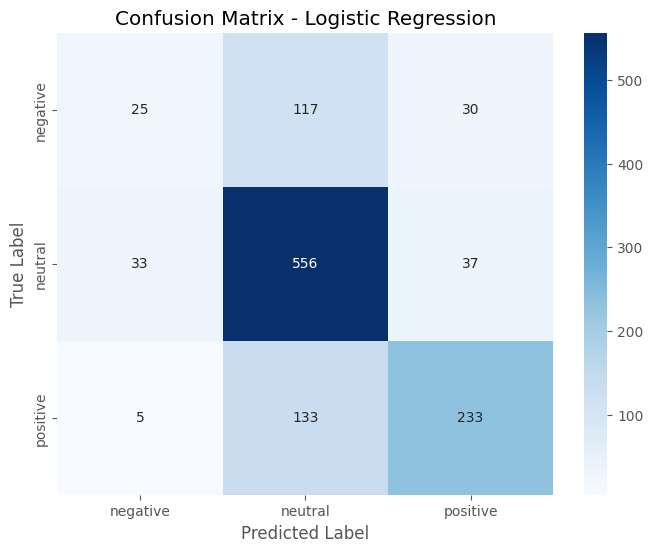

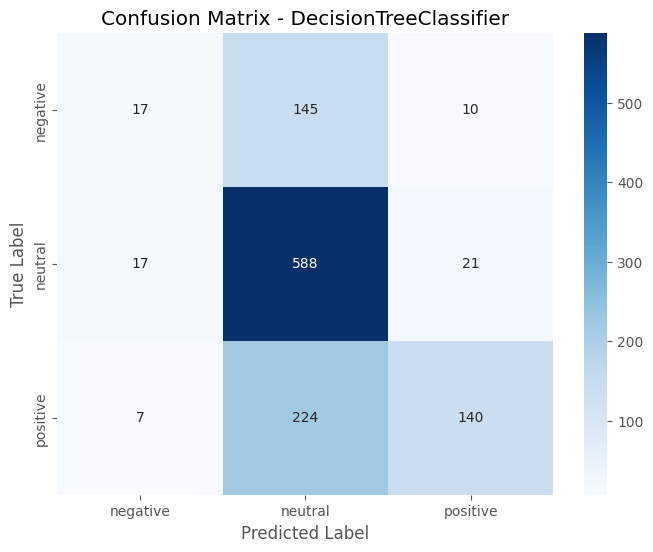

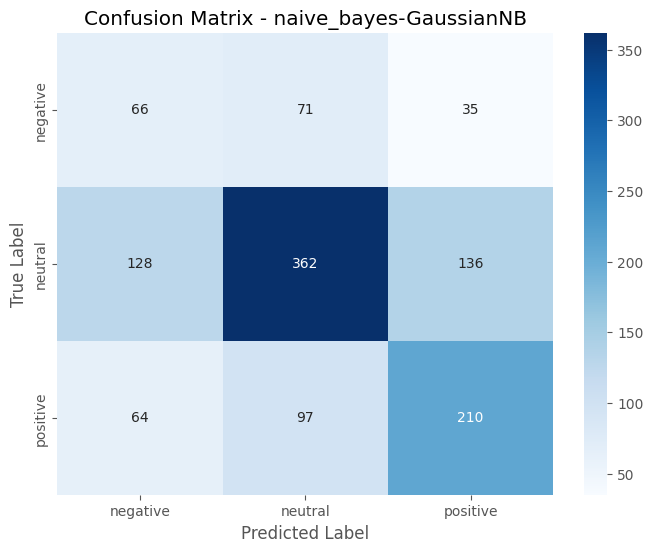

In [114]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    labels = ["negative", "neutral", "positive"]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

y_pred_lr = model_lr.predict(X_test)
plot_confusion_matrix(y_test, y_pred_lr, title="Confusion Matrix - Logistic Regression")

y_pred_lr = best_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_lr, title="Confusion Matrix - DecisionTreeClassifier")

y_pred_lr = model_nb.predict(X_test.toarray())
plot_confusion_matrix(y_test, y_pred_lr, title="Confusion Matrix - naive_bayes-GaussianNB")


# 6. Kesimpulan

### **📊 Kesimpulan Evaluasi Model Klasifikasi Sentimen**

| Model | Accuracy | Precision (Macro) | Recall (Macro) | F1-Score (Macro) | Weighted F1-Score |
|-------|----------|-------------------|----------------|------------------|-------------------|
| **Logistic Regression** | **0.696** | 0.62 | **0.55** | **0.56** | **0.67** |
| **Decision Tree (Best Model)** | 0.637 | **0.62** | 0.47 | 0.47 | 0.59 |
| **Naive Bayes (GaussianNB)** | 0.546 | 0.50 | 0.51 | 0.50 | 0.56 |

---

#### **📝 Observasi:**

1. **Logistic Regression**  
   - Memiliki **accuracy** tertinggi (**69.6%**), dan juga **weighted F1-score** terbaik (**0.67**).  
   - Model ini memiliki precision dan recall yang seimbang, meskipun sedikit bias terhadap kelas **neutral**.  
   - Kelas **negative** memiliki performa yang buruk (precision **0.40**, recall **0.15**), menunjukkan model kesulitan mengenali sentimen negatif.  

2. **Decision Tree (Best Model)**  
   - Akurasi (**63.7%**) lebih rendah dibandingkan Logistic Regression.  
   - Precision (macro avg **0.62**) bagus, tapi recall sangat rendah (**0.47**), menandakan model sering salah klasifikasi.  
   - Sering mengklasifikasikan kelas **positive** sebagai **neutral**, dan kelas **negative** juga sulit dikenali.  

3. **Naive Bayes (GaussianNB)**  
   - Akurasi terendah (**54.6%**) dengan precision dan recall yang hampir seimbang.  
   - Lebih baik dalam mengenali kelas **negative** (recall **0.38**), tapi precision masih rendah.  
   - Model ini mungkin lebih cocok jika distribusi data lebih sesuai dengan asumsi Gaussian.  

---

#### **📌 Kesimpulan Utama:**

- **Logistic Regression** adalah model dengan performa terbaik di antara ketiganya, terutama dalam menangani ketidakseimbangan kelas.  
- **Decision Tree** memiliki potensi, tapi perlu tuning lebih lanjut untuk meningkatkan recall.  
- **Naive Bayes** mungkin kurang sesuai untuk data ini karena performanya lebih rendah secara keseluruhan.  

---

#### **🚀 Langkah Berikutnya:**

- Mengatasi **class imbalance** dengan teknik seperti **SMOTE** atau **class weighting**.  
- Mempertimbangkan model lain seperti **Random Forest** atau **Support Vector Machine (SVM)** untuk peningkatan performa.  
- Menerapkan **hyperparameter tuning** yang lebih ekstensif untuk model Decision Tree.  
- Mempertimbangkan penggunaan **Word Embeddings** (misalnya, Word2Vec, BERT) untuk representasi teks yang lebih baik.  
